In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from pymer4.models import Lmer
from scipy import stats
import itertools
%matplotlib inline

# Deal with weekly predictions first

### data changes done in excel
- delete initials column
- delete duplicated row for 23952

In [2]:
wdat = pd.read_csv('../data/WeeksofDepressionDatasetforDylan.csv', index_col=0).reset_index(drop=True)

In [3]:
# make sure each subject is only in there once
assert len(wdat.groupby('SDAN')[['Participant_Type2']].count().query('Participant_Type2 > 1')) == 0
# make sure there aren't any nulls
assert wdat.isnull().sum().max() == 0
# make sure there are only MDDs in this group
assert wdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(wdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [4]:
wdat.dtypes

SDAN                                  int64
Participant_Type2                    object
SEX                                  object
Age_at_visit                        float64
Inpatient                             int64
BaselineAntiDep                       int64
BaselineOtherMeds                     int64
FUAntiDep                             int64
FUOtherMeds                           int64
dep_immed                             int64
BaselineMFQScore                    float64
s_case__neg_tot                       int64
c_ksadsdx_epset_annual_weeks_mdd      int64
dtype: object

In [5]:
wdat.describe()

,SDAN,Age_at_visit,Inpatient,BaselineAntiDep,BaselineOtherMeds,FUAntiDep,FUOtherMeds,dep_immed,BaselineMFQScore,s_case__neg_tot,c_ksadsdx_epset_annual_weeks_mdd
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000
mean,23792.680556,16.848194,0.263889,0.472222,0.319444,0.583333,0.305556,0.708333,11.759678,4.486111,21.486111
std,402.477847,1.342506,0.443833,0.502731,0.469533,0.496466,0.463875,0.457719,6.926224,3.918152,18.288758
min,22228.000000,12.840000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23666.000000,16.017500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000,3.750000
50%,23827.500000,17.080000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,11.500000,4.000000,20.000000
75%,24064.250000,17.795000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,6.000000,36.750000
max,24264.000000,18.930000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,25.005000,22.000000,57.000000


In [6]:
wdat.loc[wdat.BaselineMFQScore == 0]

,SDAN,Participant_Type2,SEX,Age_at_visit,Inpatient,BaselineAntiDep,BaselineOtherMeds,FUAntiDep,FUOtherMeds,dep_immed,BaselineMFQScore,s_case__neg_tot,c_ksadsdx_epset_annual_weeks_mdd
23,24135,MDD,FEMALE,15.17,0,0,0,0,0,1,0.0,3,0
34,23937,MDD,FEMALE,16.42,0,0,0,0,0,1,0.0,8,0


In [7]:
models = {'Null':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'FH':'c_ksadsdx_epset_annual_weeks_mdd ~ dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'MFQ':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'MFQ+FH':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + dep_immed + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          'MFQ+FH+CASE':'c_ksadsdx_epset_annual_weeks_mdd ~ BaselineMFQScore + (dep_immed*s_case__neg_tot) + BaselineAntiDep + BaselineOtherMeds + FUAntiDep + FUOtherMeds + Inpatient + SEX + Age_at_visit',
          }
model_names = list(models.keys())

In [8]:
data = wdat.copy()
def kfold_linear(data, model):
    kf = KFold(n_splits=5)
    fits = []
    reses = []
    for fix, (train_ind, test_ind) in enumerate(kf.split(data)):
        mdl = smf.ols(model, data.loc[train_ind])
        fitted = mdl.fit()
        res = data.loc[test_ind, ['SDAN'] + [mdl.endog_names]].copy()
        res[f'{mdl.endog_names}_predicted'] = fitted.predict(data.loc[test_ind])
        res['fold'] = fix
        reses.append(res)
        fits.append(fitted)
    reses = pd.concat(reses)
    return fits, reses

In [9]:
reses = []
for mix, model in models.items():
    ffs, rrs = kfold_linear(data, model)
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)

In [10]:
to_plot = reses.copy()
to_plot = to_plot.rename(
    columns={
        'c_ksadsdx_epset_annual_weeks_mdd':'Actual Weeks of Depression',
        'c_ksadsdx_epset_annual_weeks_mdd_predicted':'Predicted Weeks of Depression',
        'model': 'Model',
        'fold': 'Fold'
    })
to_plot = to_plot.rename(
    columns={})

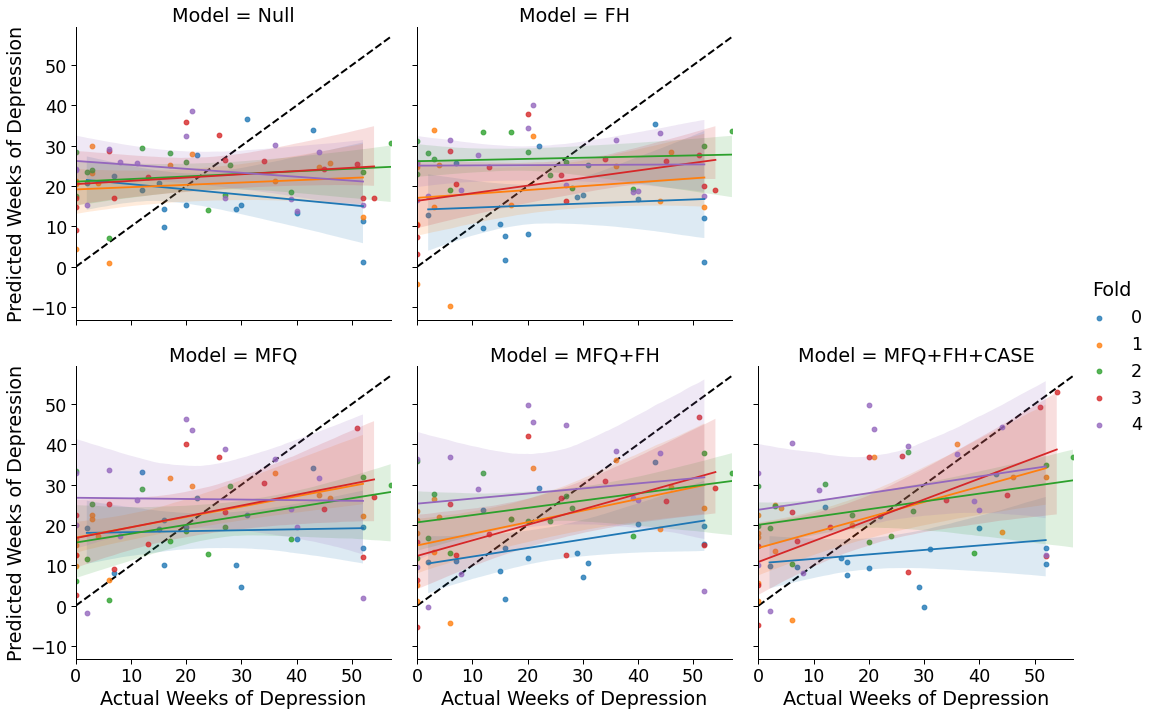

In [11]:
paper_rc = {'axes.facecolor':'white',
            'figure.facecolor':'white',
            'dpi': 250}
with sns.plotting_context("paper", font_scale=2, rc=paper_rc):
    g = sns.lmplot(x='Actual Weeks of Depression', 
               y='Predicted Weeks of Depression',
               data=to_plot,
               col='Model',
               col_wrap=3,
               col_order=['Null', 'FH', 'MFQ', 'MFQ', 'MFQ+FH', 'MFQ+FH+CASE'],
               hue='Fold',
               n_boot=10000)
    for ax in g.axes:
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.plot((xmin, xmax), (xmin, xmax),
                linestyle='dashed',
                color='black',
                linewidth=2,
                zorder=-1000)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
    g.axes[2].set_visible(False)
    g.fig.set_facecolor("white")

In [12]:
var = 'c_ksadsdx_epset_annual_weeks_mdd'
var_pred = var + '_predicted'

def get_rsquared(var, df):
    var_pred = var + '_predicted'
    num = ((df[var] - df[var_pred])**2).sum()
    den = ((df[var] - df[var].mean())**2).sum()
    r_squared = 1 - (num / den)
    return r_squared

# Test the R-squared function
test = reses.copy()
test[var_pred] = test[var]
assert (test.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)) == 1).all()

test[var_pred] = test.groupby(['model', 'fold'])[[var]].transform('mean')
assert (test.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)) == 0).all()

In [13]:
reses['squared_error'] = (reses[var] - reses[var_pred]) ** 2

In [14]:
mf_agg = reses.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)).reset_index(name='r-squared')

In [15]:
mf_agg['rmse'] = np.sqrt(reses.groupby(['model', 'fold']).squared_error.mean()).reset_index(name='rmse').loc[:, ['rmse']]

In [16]:
def get_95ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [2.5, 97.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_99ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.5, 99.5])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

def get_999ci(var, df):
    means = []
    for inds in itertools.product(df.index, repeat=len(df.index)):
        vals = []
        for ix in inds:
            vals.append(df.loc[ix, var])
        means.append(np.mean(vals))
    lci, uci = np.percentile(means, [0.05, 99.95])
    return pd.Series({f'{var}_lci': lci, f'{var}_uci':uci})

In [17]:
mf_agg

,model,fold,r-squared,rmse
0,FH,0,-0.785582,20.095455
1,FH,1,-0.249055,20.935924
2,FH,2,-0.143788,19.304679
3,FH,3,0.147378,18.210019
4,FH,4,-0.215390,19.012284
5,MFQ,0,-0.479067,18.289501
6,MFQ,1,0.261803,16.094870
7,MFQ,2,0.151716,16.624951
8,MFQ,3,0.186933,17.782602
9,MFQ,4,-0.733609,22.706598


In [18]:
df = mf_agg.copy()
var = 'rmse'
res = []
folds = df.fold.unique()
for iix, inds in enumerate(itertools.product(folds, repeat=len(folds))):
    for bsfi, ix in enumerate(inds):
        row={}
        for model in model_names:
            row['bsi'] = iix
            row['bsfold'] = bsfi
            row[f'{model}'] = df.loc[(df.model == model) & (df.fold == ix), var].values[0]
        res.append(row)
pairwise_res = pd.DataFrame(res)

In [19]:
model_pairs = list(itertools.combinations(model_names, 2))


In [20]:
model_pairs

[('Null', 'FH'),
 ('Null', 'MFQ'),
 ('Null', 'MFQ+FH'),
 ('Null', 'MFQ+FH+CASE'),
 ('FH', 'MFQ'),
 ('FH', 'MFQ+FH'),
 ('FH', 'MFQ+FH+CASE'),
 ('MFQ', 'MFQ+FH'),
 ('MFQ', 'MFQ+FH+CASE'),
 ('MFQ+FH', 'MFQ+FH+CASE')]

In [21]:
diffs_of_interest = [
     ('Null', 'FH'),
     ('Null', 'MFQ'),
     ('Null', 'MFQ+FH'),
     ('Null', 'MFQ+FH+CASE'),
     ('MFQ', 'MFQ+FH'),
     ('MFQ', 'MFQ+FH+CASE'),
     ('MFQ+FH', 'MFQ+FH+CASE')
]

In [22]:
0.05 / len(diffs_of_interest)

0.0071428571428571435

In [23]:
for mp in diffs_of_interest:
    pairwise_res[f'{mp[0]} - {mp[1]}'] = pairwise_res[mp[0]] - pairwise_res[mp[1]]

In [24]:

doi_names = [f'{dda} - {ddb}' for dda, ddb in diffs_of_interest]
to_plot = pairwise_res.groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_cis = to_plot.quantile([0.005, 0.995]).T
to_plot_means = to_plot.mean().T
to_plot_cis['meanval'] = to_plot_means
to_plot_cis = to_plot_cis.reset_index()

In [25]:
to_plot_cis[0.005] = to_plot_cis.meanval - to_plot_cis[0.005]
to_plot_cis[0.995] = to_plot_cis[0.995] - to_plot_cis.meanval

In [26]:
m_agg = mf_agg.groupby('model')[['rmse']].mean()
rmse_cis = mf_agg.groupby('model').apply(lambda x: get_99ci('rmse', x))
mr2_agg = mf_agg.groupby('model')[['r-squared']].mean()
r2_cis = mf_agg.groupby('model').apply(lambda x: get_99ci('r-squared', x))
pd.concat([m_agg,
           rmse_cis.loc[:, ['rmse_lci', 'rmse_uci']],
           mr2_agg.loc[:, ['r-squared']],
           r2_cis.loc[:, ['r-squared_lci', 'r-squared_uci']]
          ], axis=1)

,rmse,rmse_lci,rmse_uci,r-squared,r-squared_lci,r-squared_uci
model,,,,,,
FH,19.511672,18.530925,20.599736,-0.249288,-0.621119,0.045040
MFQ,18.299705,16.372633,21.424539,-0.122445,-0.600229,0.231855
MFQ+FH,18.132971,16.668875,21.490930,-0.099526,-0.571246,0.253466
MFQ+FH+CASE,17.870754,15.732969,20.487602,-0.093605,-0.620444,0.331466
Null,19.641141,18.574066,20.385852,-0.268454,-0.676711,0.007769


In [27]:
to_plot_cis.loc[:, [0.005, 0.995]].T.values

array([[1.84934276, 1.48738461, 0.81559753, 2.03658641, 2.81369683,
        2.61636738, 1.27307622],
       [1.0946325 , 1.44609911, 0.88447053, 2.15936695, 1.4433037 ,
        1.83418698, 1.16190205]])

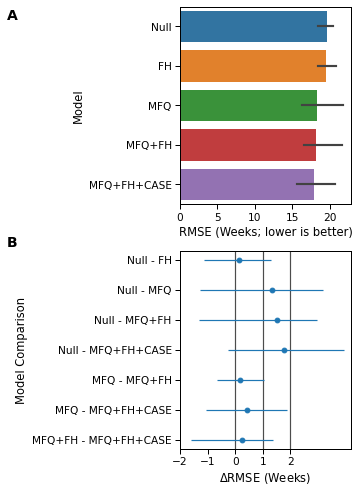

In [28]:
to_plot_a = mf_agg
to_plot_a = to_plot_a.rename(columns = {
    'model': 'Model',
    'rmse': 'RMSE',
})

with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

    fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=False)
    ax = axes[0]
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel('RMSE (Weeks; lower is better)')
    ax.get_figure().set_facecolor("white")

    ax = axes[1]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.005, 0.995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 2], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_xlabel('$\Delta$RMSE (Weeks)')

    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

In [29]:
doi_names

['Null - FH',
 'Null - MFQ',
 'Null - MFQ+FH',
 'Null - MFQ+FH+CASE',
 'MFQ - MFQ+FH',
 'MFQ - MFQ+FH+CASE',
 'MFQ+FH - MFQ+FH+CASE']

In [30]:
difs = [
     ('Null - FH'),
     ('MFQ - MFQ+FH'),
]

In [31]:
(((pairwise_res.groupby('bsi').mean().loc[:, difs].max(1) > 1).sum())) / len(pairwise_res.bsi.unique()), len(pairwise_res.bsi.unique())

(0.03904, 3125)

In [32]:
difs = [
     'MFQ+FH - MFQ+FH+CASE'
]

In [33]:
(((pairwise_res.groupby('bsi').mean().loc[:, difs].max(1) > 1).sum())) / len(pairwise_res.bsi.unique()), len(pairwise_res.bsi.unique())

(0.12544, 3125)

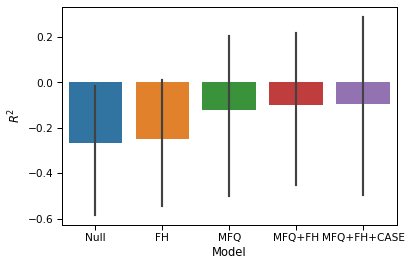

In [34]:
with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):
    ax = sns.barplot(x="Model", y='r-squared', data=to_plot_a, order=models.keys())
    ax.set_ylabel('$R^2$')
    ax.get_figure().set_facecolor("white")

In [35]:
reses.to_csv('../data/weekly_cv_predictions.csv', index=None)


In [36]:
## fit models to everything
model_name = list(models.keys())[0]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

Fitting Null Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.118
Model:                                          OLS   Adj. R-squared:                  0.022
Method:                               Least Squares   F-statistic:                     1.224
Date:                              Tue, 18 May 2021   Prob (F-statistic):              0.303
Time:                                      21:10:35   Log-Likelihood:                -306.39
No. Observations:                                72   AIC:                             628.8
Df Residuals:                                    64   BIC:                             647.0
Df Model:                                         7                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.6494     27.411      0.097      0.923     -52.110      57.409
SEX[T.MALE]          -3.8641      5.000     -0.773      0.442     -13.852       6.124
BaselineAntiDep       0.5827      5.374      0.108      0.914     -10.153      11.318
BaselineOtherMeds   -10.1708      5.938     -1.713      0.092     -22.033       1.691
FUAntiDep             8.3107      5.354      1.552      0.126      -2.385      19.006
FUOtherMeds           1.8118      6.243      0.290      0.773     -10.660      14.284
Inpatient             6.6878      5.420      1.234      0.222      -4.141      17.517
Age_at_visit          0.9329      1.630      0.572      0.569      -2.323       4.189
==============================================================================
Omnibus:                        9.863   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                6.329
Skew:                           0.572   Prob(JB):                       0.0422
Kurtosis:                       2.105   Cond. No.                         219.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
## fit models to everything
model_name = list(models.keys())[1]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

Fitting FH Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.188
Model:                                          OLS   Adj. R-squared:                  0.084
Method:                               Least Squares   F-statistic:                     1.818
Date:                              Tue, 18 May 2021   Prob (F-statistic):             0.0903
Time:                                      21:10:35   Log-Likelihood:                -303.44
No. Observations:                                72   AIC:                             624.9
Df Residuals:                                    63   BIC:                             645.4
Df Model:                                         8                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.1363     26.713      0.379      0.706     -43.246      63.519
SEX[T.MALE]          -3.8626      4.837     -0.799      0.428     -13.529       5.803
dep_immed            10.8938      4.695      2.320      0.024       1.511      20.277
BaselineAntiDep       0.0045      5.205      0.001      0.999     -10.396      10.405
BaselineOtherMeds    -9.3594      5.755     -1.626      0.109     -20.860       2.141
FUAntiDep             8.1140      5.180      1.566      0.122      -2.238      18.466
FUOtherMeds           1.5941      6.040      0.264      0.793     -10.477      13.665
Inpatient             6.4398      5.245      1.228      0.224      -4.041      16.921
Age_at_visit          0.0460      1.623      0.028      0.977      -3.196       3.288
==============================================================================
Omnibus:                        8.046   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                3.850
Skew:                           0.324   Prob(JB):                        0.146
Kurtosis:                       2.071   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
## fit models to everything
model_name = list(models.keys())[2]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

Fitting MFQ Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.268
Model:                                          OLS   Adj. R-squared:                  0.175
Method:                               Least Squares   F-statistic:                     2.889
Date:                              Tue, 18 May 2021   Prob (F-statistic):            0.00832
Time:                                      21:10:35   Log-Likelihood:                -299.66
No. Observations:                                72   AIC:                             617.3
Df Residuals:                                    63   BIC:                             637.8
Df Model:                                         8                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             9.4137     25.234      0.373      0.710     -41.012      59.839
SEX[T.MALE]          -5.2002      4.605     -1.129      0.263     -14.402       4.002
BaselineMFQScore      1.1488      0.319      3.597      0.001       0.511       1.787
BaselineAntiDep       6.0416      5.161      1.171      0.246      -4.273      16.356
BaselineOtherMeds   -13.0777      5.511     -2.373      0.021     -24.090      -2.066
FUAntiDep             4.6911      5.017      0.935      0.353      -5.334      14.717
FUOtherMeds           2.1289      5.732      0.371      0.712      -9.325      13.583
Inpatient             2.4038      5.117      0.470      0.640      -7.821      12.629
Age_at_visit         -0.1596      1.527     -0.105      0.917      -3.211       2.892
==============================================================================
Omnibus:                        4.537   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                4.526
Skew:                           0.590   Prob(JB):                        0.104
Kurtosis:                       2.659   Cond. No.                         272.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
## fit models to everything
model_name = list(models.keys())[3]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

Fitting MFQ+FH Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.342
Model:                                          OLS   Adj. R-squared:                  0.247
Method:                               Least Squares   F-statistic:                     3.588
Date:                              Tue, 18 May 2021   Prob (F-statistic):            0.00121
Time:                                      21:10:35   Log-Likelihood:                -295.82
No. Observations:                                72   AIC:                             611.6
Df Residuals:                                    62   BIC:                             634.4
Df Model:                                         9                                         
Covariance Type:                          nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            17.2532     24.297      0.710      0.480     -31.315      65.821
SEX[T.MALE]          -5.2194      4.401     -1.186      0.240     -14.016       3.578
BaselineMFQScore      1.1667      0.305      3.822      0.000       0.556       1.777
dep_immed            11.2538      4.259      2.642      0.010       2.740      19.767
BaselineAntiDep       5.5292      4.936      1.120      0.267      -4.339      15.397
BaselineOtherMeds   -12.2847      5.275     -2.329      0.023     -22.829      -1.741
FUAntiDep             4.4317      4.795      0.924      0.359      -5.154      14.018
FUOtherMeds           1.9089      5.478      0.348      0.729      -9.042      12.860
Inpatient             2.0810      4.891      0.425      0.672      -7.696      11.859
Age_at_visit         -1.0929      1.501     -0.728      0.469      -4.094       1.908
==============================================================================
Omnibus:                        2.326   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.313   Jarque-Bera (JB):                2.304
Skew:                           0.401   Prob(JB):                        0.316
Kurtosis:                       2.646   Cond. No.                         274.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
## fit models to everything
model_name = list(models.keys())[4]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = smf.ols(model, data)
fitted = mdl.fit()
fitted.summary()

Fitting MFQ+FH+CASE Model to all data, don't use these fit statistics.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     c_ksadsdx_epset_annual_weeks_mdd   R-squared:                       0.399
Model:                                          OLS   Adj. R-squared:                  0.288
Method:                               Least Squares   F-statistic:                     3.615
Date:                              Tue, 18 May 2021   Prob (F-statistic):           0.000597
Time:                                      21:10:35   Log-Likelihood:                -292.61
No. Observations:                                72   AIC:                             609.2
Df Residuals:                                    60   BIC:                             636.5
Df Model:                                        11                                         
Covariance Type:                          nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    20.3421     24.341      0.836      0.407     -28.347      69.031
SEX[T.MALE]                  -4.2839      4.322     -0.991      0.326     -12.929       4.361
BaselineMFQScore              0.9013      0.324      2.779      0.007       0.253       1.550
dep_immed                     7.6108      7.335      1.038      0.304      -7.062      22.283
s_case__neg_tot               0.4745      1.266      0.375      0.709      -2.057       3.006
dep_immed:s_case__neg_tot     0.8713      1.344      0.648      0.519      -1.818       3.560
BaselineAntiDep               5.1646      5.161      1.001      0.321      -5.160      15.489
BaselineOtherMeds           -10.5036      5.199     -2.020      0.048     -20.903      -0.105
FUAntiDep                     4.5618      4.957      0.920      0.361      -5.354      14.477
FUOtherMeds                   0.2368      5.376      0.044      0.965     -10.516      10.990
Inpatient                     4.0317      4.960      0.813      0.420      -5.890      13.954
Age_at_visit                 -1.2724      1.463     -0.870      0.388      -4.198       1.654
==============================================================================
Omnibus:                        2.956   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.228   Jarque-Bera (JB):                2.856
Skew:                           0.432   Prob(JB):                        0.240
Kurtosis:                       2.548   Cond. No.                         294.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# deal with mfq predictions

In [41]:
mdat = pd.read_csv('../data/MFQAnalysesDatabaseforDylan.csv', index_col=0).reset_index(drop=True)
bsl_mfqs = mdat.sort_values(['SDAN', 'Clinical_Visit_Date']).groupby('SDAN')[['MFQtminus1']].first().reset_index().rename(columns={'MFQtminus1':'baseline_mfq'})
mdat = mdat.merge(bsl_mfqs, how='left', on='SDAN')

In [42]:
mdat['TimeBetween'] = mdat.TimeBetween / 365
mdat['Time2'] = mdat.TimeBetween ** 2

In [43]:
models = {
    'Null': 's_mfq_tot ~ antidepressants + TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'FH': 's_mfq_tot ~ dep_immed*TimeBetween + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+FH': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + dep_immed + dep_immed:TimeBetween + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',    
    'MFQ': 's_mfq_tot ~ antidepressants + TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH': 's_mfq_tot ~ dep_immed*TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ+FH_T2': 's_mfq_tot ~ dep_immed*TimeBetween + dep_immed:Time2 + Time2 + MFQtminus1 + InpatientDuring + Age_at_visit + SEX + antidepressants + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+MFQ': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
    'MFQ0+MFQ+FH': 's_mfq_tot ~ antidepressants + TimeBetween*baseline_mfq + dep_immed + dep_immed:TimeBetween + MFQtminus1 + InpatientDuring + Age_at_visit + SEX  + OtherMeds + postpandemic + (TimeBetween | SDAN)',
}
model_names = list(models.keys())

In [44]:
mdat['dep_immed:TimeBetween'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:dep_immed'] = mdat.dep_immed * mdat.TimeBetween
mdat['dep_immed:Time2'] = mdat.dep_immed * mdat.TimeBetween
mdat['TimeBetween:MFQtminus1'] = mdat.MFQtminus1 * mdat.TimeBetween
mdat['TimeBetween:baseline_mfq'] = mdat.baseline_mfq * mdat.TimeBetween

In [45]:
# make sure there aren't any nulls
assert mdat.isnull().sum().max() == 0
# make sure there are only MDDs in this group
assert mdat.Participant_Type2.unique()[0] == 'MDD'
# make sure there are only male and femal in the sex column
assert set(mdat.SEX.unique()) == {'FEMALE', 'MALE'}

In [46]:
mdat['InpatientDuring'] = mdat.InpatientDuring.astype(int)
mdat['postpandemic'] = mdat.postpandemic.astype(int)
mdat['SEX'] = (mdat.SEX == "MALE").astype(int)

In [47]:
def kfold_lme(data, model):
    gkf = GroupKFold(n_splits=5)
    fit_mdls = []
    reses = []
    for tix,(train_ind, test_ind) in enumerate(gkf.split(data, groups=data.SDAN)):
        mdl = Lmer(model, data.loc[train_ind])
        _ = mdl.fit()
        y_name = model.split("~")[0].strip()
        res = data.loc[test_ind, ['SDAN'] + [y_name]].copy()
        res[f'{y_name}_predicted'] = mdl.predict(data.loc[test_ind])
        res['fold'] = tix
        reses.append(res)
        fit_mdls.append(mdl)
    reses = pd.concat(reses)
    return fit_mdls, reses

In [48]:
reses = []
for mix, model in models.items():
    ffs, rrs = kfold_lme(mdat, model)
    rrs['model'] = mix
    reses.append(rrs)
reses = pd.concat(reses)

Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1048	 Groups: {'SDAN': 104.0}

Log-likelihood: -3170.379 	 AIC: 6340.758

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  22.695  4.764
SDAN      TimeBetween  26.344  5.133
Residual               19.349  4.399

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.314

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1049	 Groups: {'SDAN': 104.0}

Log-likelihood: -3200.170 	 AIC: 6400.340

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.526  5.052
SDAN      TimeBetween  44.044  6.637
Residual               20.058  4.479

              IV1          IV2   Corr
SDAN  (Interc

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1049	 Groups: {'SDAN': 104.0}

Log-likelihood: -3159.240 	 AIC: 6318.479

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  15.042  3.878
SDAN      TimeBetween  45.766  6.765
Residual               19.875  4.458

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.691

Fixed effects:

Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1049	 Groups: {'SDAN': 104.0}

Log-likelihood: -3133.216 	 AIC: 6266.433

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  14.426  3.798
SDAN      TimeBetween  33.366  5.776

Formula: s_mfq_tot~dep_immed*TimeBetween+dep_immed:Time2+Time2+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1049	 Groups: {'SDAN': 104.0}

Log-likelihood: -3033.317 	 AIC: 6066.635

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.018  1.737
SDAN      TimeBetween  27.458  5.240
Residual               17.154  4.142

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.577

Fixed effects:

Formula: s_mfq_tot~dep_immed*TimeBetween+dep_immed:Time2+Time2+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1049	 Groups: {'SDAN': 104.0}

Log-likelihood: -3020.960 	 AIC: 6041.921

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.525  1.877
SDAN      TimeBetween  15.265  3.907
Res

In [49]:
to_plot = reses.copy()
to_plot = to_plot.rename(
    columns={
        's_mfq_tot':'Actual MFQ Scores',
        's_mfq_tot_predicted':'Predicted MFQ Scores',
        'model': 'Model',
        'fold': 'Fold'
    })

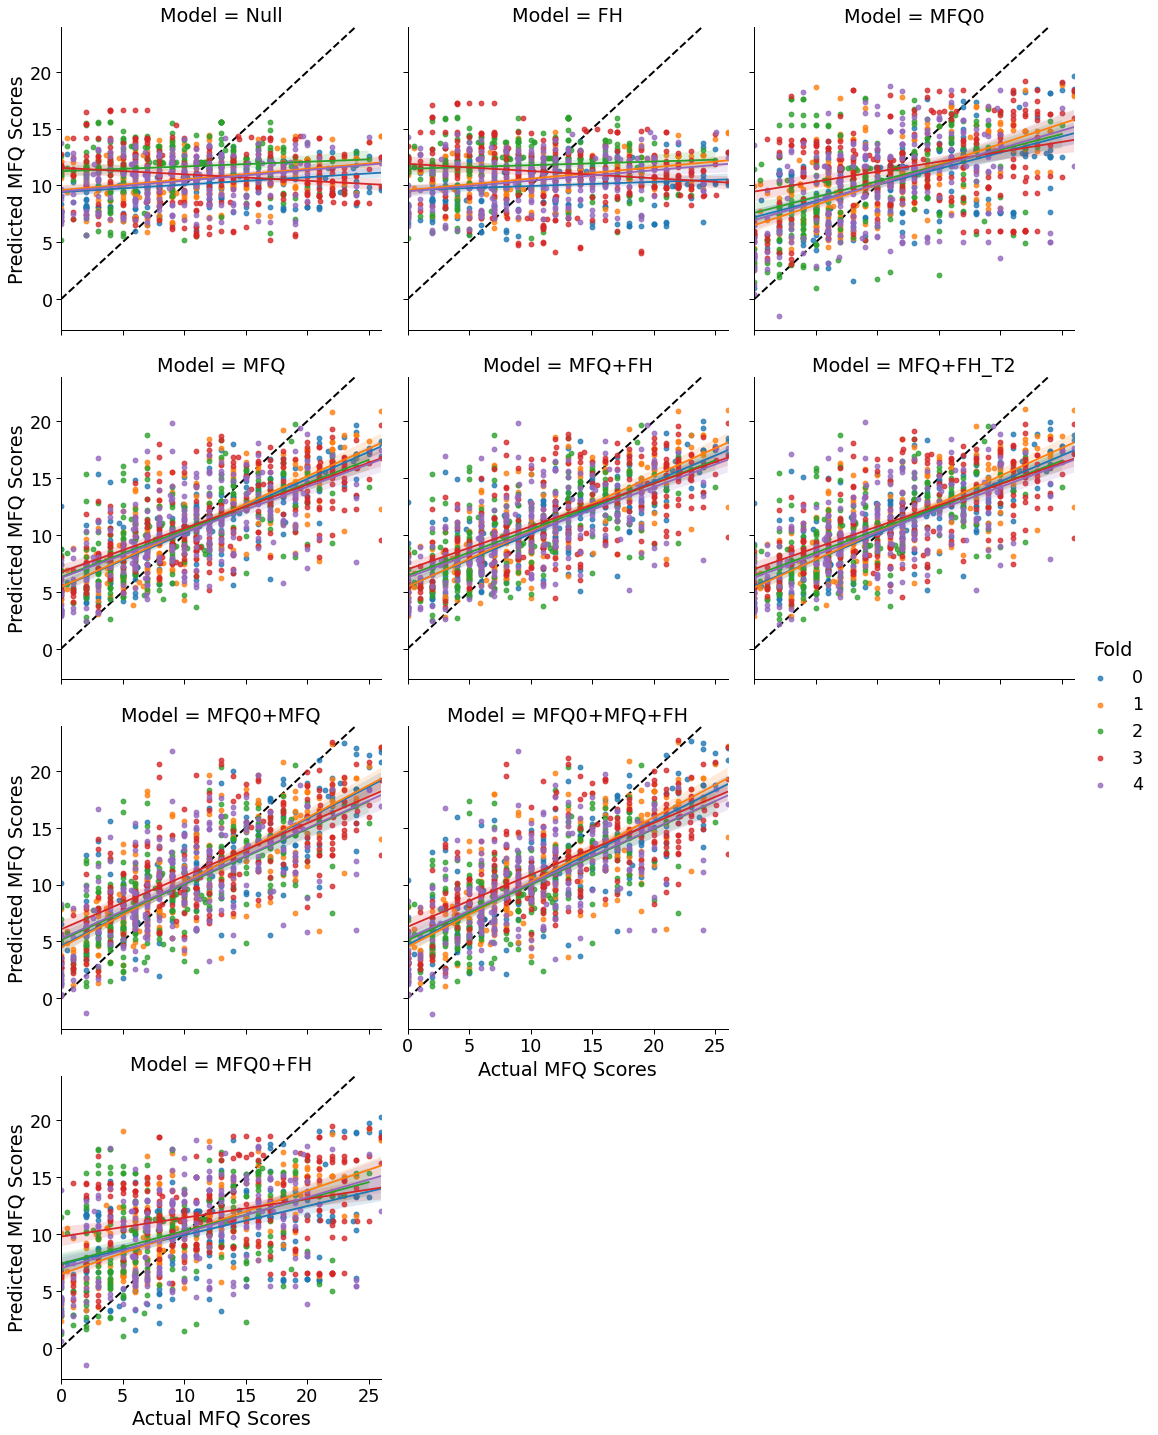

In [50]:
paper_rc = {'axes.facecolor':'white',
            'figure.facecolor':'white',
            'dpi': 250}
with sns.plotting_context("paper", font_scale=2, rc=paper_rc):
    g = sns.lmplot(x='Actual MFQ Scores', 
               y='Predicted MFQ Scores',
               data=to_plot,
               col='Model',
               col_wrap=3,
               col_order=['Null', 'FH', 'MFQ0', 'MFQ', 'MFQ+FH', 'MFQ+FH_T2', 'MFQ0+MFQ',  'MFQ0+MFQ+FH', 'no plot', 'MFQ0+FH'],
               hue='Fold',
               n_boot=10000)
    for ax in g.axes:
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        ax.plot((xmin, xmax), (xmin, xmax),
                linestyle='dashed',
                color='black',
                linewidth=2,
                zorder=-1000)
        ax.set_ylim((ymin, ymax))
        ax.set_xlim((xmin, xmax))
    g.axes[8].set_visible(False)
#     g.fig.set_facecolor("white")

In [51]:
#reses.to_csv('../data/mfq_cv_predictions.csv', index=None)

In [52]:
var = 's_mfq_tot'
var_pred = var + '_predicted'

In [53]:
mf_agg = reses.groupby(['model', 'fold']).apply(lambda x: get_rsquared(var, x)).reset_index(name='r-squared')

In [54]:
reses['squared_error'] = (reses[var] - reses[var_pred]) ** 2
mf_agg['rmse'] = np.sqrt(reses.groupby(['model', 'fold']).squared_error.mean()).reset_index(name='rmse').loc[:, ['rmse']]

In [55]:
m_agg = mf_agg.groupby('model')[['rmse']].mean()
rmse_cis = mf_agg.groupby('model').apply(lambda x: get_95ci('rmse', x))
mr2_agg = mf_agg.groupby('model')[['r-squared']].mean()
r2_cis = mf_agg.groupby('model').apply(lambda x: get_95ci('r-squared', x))

pd.concat([m_agg,
           rmse_cis.loc[:, ['rmse_lci', 'rmse_uci']],
           mr2_agg.loc[:, ['r-squared']],
           r2_cis.loc[:, ['r-squared_lci', 'r-squared_uci']]
          ], axis=1)

,rmse,rmse_lci,rmse_uci,r-squared,r-squared_lci,r-squared_uci
model,,,,,,
FH,6.644581,5.981795,7.390242,-0.096417,-0.247570,0.054736
MFQ,4.522304,4.257265,4.875021,0.486588,0.413662,0.561699
MFQ+FH,4.568437,4.296347,4.937022,0.476899,0.405961,0.547838
MFQ+FH_T2,4.569580,4.295949,4.942771,0.476698,0.405901,0.547496
MFQ0,5.650301,5.175580,6.261717,0.202865,0.094647,0.324380
MFQ0+FH,5.708361,5.165729,6.335223,0.188730,0.101135,0.312219
MFQ0+MFQ,4.318439,4.043481,4.627267,0.530101,0.455454,0.605667
MFQ0+MFQ+FH,4.355210,4.112456,4.656086,0.523526,0.455240,0.591812
Null,6.552565,5.977612,7.288691,-0.066284,-0.202658,0.067218


In [56]:
df = mf_agg.copy()
var = 'rmse'
res = []
folds = df.fold.unique()
for iix, inds in enumerate(itertools.product(folds, repeat=len(folds))):
    for bsfi, ix in enumerate(inds):
        row={}
        for model in model_names:
            row['bsi'] = iix
            row['bsfold'] = bsfi
            row[f'{model}'] = df.loc[(df.model == model) & (df.fold == ix), var].values[0]
        res.append(row)
pairwise_res = pd.DataFrame(res)

In [57]:
model_pairs = list(itertools.combinations(model_names, 2))
diffs_of_interest = [
    ('Null', 'FH'),
    ('Null', 'MFQ'),
    ('Null', 'MFQ0'),
    ('MFQ0', 'MFQ0+FH'),    
    ('MFQ0', 'MFQ'),
    ('MFQ', 'MFQ+FH'),
    ('MFQ', 'MFQ+FH_T2'),
    ('MFQ', 'MFQ0+MFQ'),
    ('MFQ', 'MFQ0+MFQ+FH'),
    ('Null', 'MFQ0+MFQ'),
]

In [58]:
for mp in diffs_of_interest:
    pairwise_res[f'{mp[0]} - {mp[1]}'] = pairwise_res[mp[0]] - pairwise_res[mp[1]]

In [59]:
to_plot = mf_agg
to_plot = to_plot.rename(columns = {
    'model': 'Model',
    'rmse': 'RMSE',
})


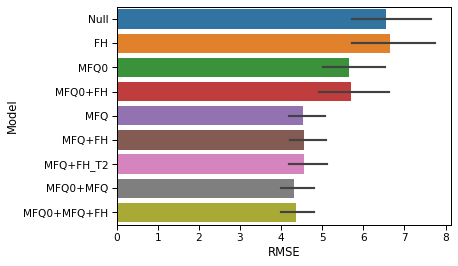

In [60]:
with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot, order=model_names, ci=99.9)
    ax.get_figure().set_facecolor("white")

In [61]:
doi_names = [f'{dda} - {ddb}' for dda, ddb in diffs_of_interest]
to_plot = pairwise_res.groupby('bsi').mean().loc[:, doi_names[::-1]]
to_plot_cis = to_plot.quantile([0.0005, 0.9995]).T
to_plot_means = to_plot.mean().T
to_plot_cis['meanval'] = to_plot_means
to_plot_cis = to_plot_cis.reset_index()
to_plot_cis[0.0005] = to_plot_cis.meanval - to_plot_cis[0.0005]
to_plot_cis[0.9995] = to_plot_cis[0.9995] - to_plot_cis.meanval

In [62]:
to_plot_cis

,index,0.0005,0.9995,meanval
0,Null - MFQ0+MFQ,0.905573,0.721638,2.234125
1,MFQ - MFQ0+MFQ+FH,0.115641,0.122088,0.167094
2,MFQ - MFQ0+MFQ,0.124529,0.097871,0.203865
3,MFQ - MFQ+FH_T2,0.079206,0.059159,-0.047276
4,MFQ - MFQ+FH,0.075937,0.054286,-0.046133
5,MFQ0 - MFQ,0.406282,0.405200,1.127997
6,MFQ0 - MFQ0+FH,0.287874,0.108063,-0.058060
7,Null - MFQ0,0.502333,0.286139,0.902264
8,Null - MFQ,0.781044,0.623854,2.030261
9,Null - FH,0.172933,0.157956,-0.092017


In [63]:
to_plot_cis.loc[:, [0.0005, 0.9995]].T.values

array([[0.90557312, 0.11564057, 0.12452939, 0.07920628, 0.07593659,
        0.40628169, 0.28787402, 0.50233319, 0.78104372, 0.17293284],
       [0.72163839, 0.1220881 , 0.09787117, 0.05915884, 0.05428595,
        0.40520001, 0.1080632 , 0.28613852, 0.62385412, 0.15795639]])

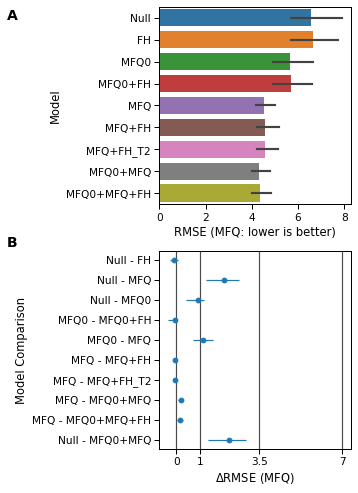

In [64]:
to_plot_a = mf_agg
to_plot_a = to_plot_a.rename(columns = {
    'model': 'Model',
    'rmse': 'RMSE',
})

with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):

    fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=False)
    ax = axes[0]
    ax = sns.barplot(y="Model", x='RMSE', data=to_plot_a, order=model_names, ci=99.9, ax=ax)
    ax.set_xlabel(None)
    ax.get_figure().set_facecolor("white")
    ax.set_xlabel('RMSE (MFQ: lower is better)')

    ax = axes[1]
    ax.errorbar(x=to_plot_cis.meanval,
                xerr=to_plot_cis.loc[:, [0.0005, 0.9995]].T.values,
                y=to_plot_cis.index.values,
                fmt='o')
    ax.set_yticks(to_plot_cis.index.values)
    ax.set_yticklabels(to_plot_cis['index'].values)
    ymin, ymax = ax.get_ylim()
    ax.vlines([0, 1, 3.5, 7], ymin, ymax,colors='black', zorder=-10, alpha =0.7)
    ax.set_ylim((ymin, ymax))
    ax.set_xlabel('$\Delta$RMSE (MFQ)')
    ax.set_ylabel('Model Comparison')
    ax.set_xticks([0,1,3.5, 7])
    ax.set_xticklabels([0,1,3.5, 7])
    fig.set_facecolor('white')
    fig.tight_layout()
    fig.text(0.01, 0.95, 'A', fontsize=14, fontweight='bold')
    fig.text(0.01, 0.5, 'B', fontsize=14, fontweight='bold')

Do test on family history

In [65]:
fh_difs = [dd for dd in doi_names if 'FH' in dd]

In [66]:
fh_difs

['Null - FH',
 'MFQ0 - MFQ0+FH',
 'MFQ - MFQ+FH',
 'MFQ - MFQ+FH_T2',
 'MFQ - MFQ0+MFQ+FH']

In [67]:
(((pairwise_res.groupby('bsi').mean().loc[:, fh_difs].max(1) > 1).sum()) + 1) / len(pairwise_res.bsi.unique()), len(pairwise_res.bsi.unique())

(0.00032, 3125)

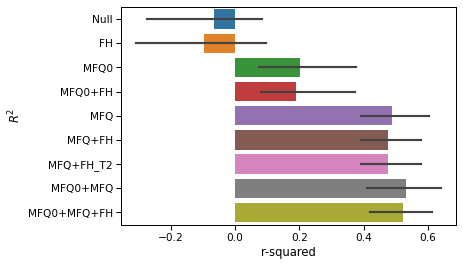

In [70]:
with sns.plotting_context("paper", font_scale=1.2, rc=paper_rc):
    ax = sns.barplot(y="Model", x='r-squared', data=to_plot_a, order=model_names, ci=99.9)
    ax.set_ylabel('$R^2$')
    ax.get_figure().set_facecolor("white")

In [71]:
reses.to_csv('../data/mfq_cv_predictions.csv', index=None)

In [72]:
## fit models to everything
model_name = list(models.keys())[0]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting Null Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3958.141 	 AIC: 7916.282

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.339  5.034
SDAN      TimeBetween  31.179  5.584
Residual               18.805  4.337

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.373

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.806,15.366,28.246,3.286,307.770,6.636,0.000,***
antidepressants,-0.041,-2.073,1.992,1.037,115.336,-0.039,0.969,
TimeBetween,-1.190,-2.906,0.526,0.875,75.929,-1.359,0.178,
InpatientDuring,-0.323,-1.357,0.712,0.528,1166.264,-0.612,0.541,
Age_at_visit,-0.557,-0.962,-0.151,0.207,306.549,-2.692,0.008,**
SEX,-3.381,-5.405,-1.357,1.033,116.063,-3.274,0.001,**
OtherMeds,0.614,-1.659,2.886,1.159,113.868,0.529,0.598,
postpandemic,-1.065,-1.909,-0.221,0.431,813.460,-2.473,0.014,*


In [73]:
## fit models to everything
model_name = list(models.keys())[1]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~dep_immed*TimeBetween+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3954.906 	 AIC: 7909.813

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  25.151  5.015
SDAN      TimeBetween  32.215  5.676
Residual               18.801  4.336

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.369

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),21.053,14.477,27.628,3.355,285.224,6.275,0.000,***
dep_immed,1.280,-0.928,3.487,1.126,111.068,1.136,0.258,
TimeBetween,-0.993,-4.286,2.300,1.680,67.542,-0.591,0.557,
InpatientDuring,-0.325,-1.360,0.710,0.528,1166.259,-0.616,0.538,
Age_at_visit,-0.568,-0.974,-0.163,0.207,303.175,-2.747,0.006,**
SEX,-3.296,-5.320,-1.272,1.033,114.502,-3.192,0.002,**
antidepressants,-0.098,-2.127,1.931,1.035,113.941,-0.095,0.925,
OtherMeds,0.606,-1.661,2.873,1.157,112.498,0.524,0.602,
postpandemic,-1.049,-1.893,-0.204,0.431,808.576,-2.434,0.015,*
dep_immed:TimeBetween,-0.274,-4.087,3.540,1.946,66.891,-0.141,0.888,


In [74]:
## fit models to everything
model_name = list(models.keys())[2]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0 Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3912.391 	 AIC: 7824.782

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  14.115  3.757
SDAN      TimeBetween  33.524  5.790
Residual               18.673  4.321

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.659

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.947,5.516,16.378,2.771,223.910,3.950,0.000,***
antidepressants,0.000,-1.389,1.390,0.709,111.782,0.001,0.999,
TimeBetween,-4.485,-7.724,-1.246,1.653,84.681,-2.714,0.008,**
baseline_mfq,0.509,0.382,0.636,0.065,138.285,7.838,0.000,***
InpatientDuring,-0.184,-1.201,0.833,0.519,1220.451,-0.354,0.723,
Age_at_visit,-0.226,-0.545,0.093,0.163,211.756,-1.387,0.167,
SEX,-1.386,-2.806,0.034,0.725,111.381,-1.913,0.058,.
OtherMeds,-0.223,-1.777,1.332,0.793,109.726,-0.281,0.779,
postpandemic,-1.457,-2.212,-0.703,0.385,837.948,-3.788,0.000,***
TimeBetween:baseline_mfq,0.305,0.022,0.588,0.144,86.894,2.111,0.038,*


In [75]:
## fit models to everything
model_name = list(models.keys())[3]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0+FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3908.811 	 AIC: 7817.623

Random effects:

                 Name     Var    Std
SDAN      (Intercept)  13.921  3.731
SDAN      TimeBetween  34.562  5.879
Residual               18.664  4.320

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.658

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),10.311,4.808,15.814,2.808,217.183,3.672,0.000,***
antidepressants,-0.052,-1.432,1.329,0.704,111.089,-0.074,0.942,
TimeBetween,-4.301,-8.618,0.016,2.203,78.575,-1.953,0.054,.
baseline_mfq,0.506,0.379,0.633,0.065,137.555,7.829,0.000,***
dep_immed,1.278,-0.461,3.017,0.887,120.192,1.440,0.152,
InpatientDuring,-0.184,-1.201,0.834,0.519,1220.335,-0.354,0.724,
Age_at_visit,-0.241,-0.559,0.076,0.162,210.879,-1.488,0.138,
SEX,-1.331,-2.744,0.081,0.721,110.431,-1.847,0.067,.
OtherMeds,-0.236,-1.779,1.307,0.787,109.186,-0.299,0.765,
postpandemic,-1.435,-2.189,-0.682,0.384,836.629,-3.733,0.000,***


In [76]:
## fit models to everything
model_name = list(models.keys())[4]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3777.139 	 AIC: 7554.277

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.217  1.794
SDAN      TimeBetween  12.070  3.474
Residual               16.690  4.085

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.483

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.692,4.134,11.249,1.815,90.787,4.238,0.000,***
antidepressants,0.037,-0.830,0.904,0.442,51.563,0.083,0.934,
TimeBetween,-0.729,-2.059,0.600,0.678,52.647,-1.075,0.287,
MFQtminus1,0.585,0.541,0.628,0.022,583.253,26.253,0.000,***
InpatientDuring,-0.769,-1.650,0.112,0.449,723.206,-1.711,0.087,.
Age_at_visit,-0.159,-0.374,0.056,0.110,79.812,-1.447,0.152,
SEX,-1.346,-2.210,-0.482,0.441,50.099,-3.054,0.004,**
OtherMeds,0.403,-0.561,1.368,0.492,50.757,0.820,0.416,
postpandemic,-0.366,-0.990,0.258,0.318,650.230,-1.149,0.251,


In [77]:
## fit models to everything
model_name = list(models.keys())[5]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ+FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~dep_immed*TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3774.841 	 AIC: 7549.682

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.269  1.808
SDAN      TimeBetween  13.187  3.631
Residual               16.646  4.080

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.482

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.488,3.883,11.093,1.839,92.464,4.071,0.000,***
dep_immed,0.672,-0.387,1.731,0.540,69.203,1.244,0.218,
TimeBetween,-0.319,-2.908,2.270,1.321,45.452,-0.242,0.810,
MFQtminus1,0.581,0.538,0.625,0.022,609.526,26.008,0.000,***
InpatientDuring,-0.772,-1.654,0.110,0.450,735.381,-1.716,0.087,.
Age_at_visit,-0.173,-0.390,0.044,0.111,83.467,-1.566,0.121,
SEX,-1.332,-2.200,-0.463,0.443,51.272,-3.005,0.004,**
antidepressants,0.011,-0.860,0.882,0.444,52.946,0.024,0.981,
OtherMeds,0.389,-0.579,1.358,0.494,52.259,0.788,0.434,
postpandemic,-0.353,-0.979,0.272,0.319,655.301,-1.106,0.269,


In [78]:
## fit models to everything
model_name = list(models.keys())[6]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ+FH_T2 Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~dep_immed*TimeBetween+dep_immed:Time2+Time2+MFQtminus1+InpatientDuring+Age_at_visit+SEX+antidepressants+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3771.164 	 AIC: 7542.328

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   3.364  1.834
SDAN      TimeBetween  15.558  3.944
Residual               16.580  4.072

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.496

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),7.498,3.874,11.123,1.849,95.055,4.055,0.000,***
dep_immed,0.542,-0.621,1.706,0.594,80.888,0.913,0.364,
TimeBetween,0.018,-4.294,4.330,2.200,55.102,0.008,0.994,
Time2,-0.338,-4.259,3.583,2.001,19.417,-0.169,0.868,
MFQtminus1,0.582,0.538,0.626,0.022,615.991,25.950,0.000,***
InpatientDuring,-0.662,-1.568,0.244,0.462,757.018,-1.432,0.153,
Age_at_visit,-0.179,-0.396,0.038,0.111,84.085,-1.615,0.110,
SEX,-1.300,-2.174,-0.427,0.446,52.240,-2.918,0.005,**
antidepressants,-0.009,-0.883,0.865,0.446,53.627,-0.020,0.984,
OtherMeds,0.389,-0.582,1.361,0.496,52.847,0.785,0.436,


In [79]:
## fit models to everything
model_name = list(models.keys())[7]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0+MFQ Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3744.694 	 AIC: 7489.387

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   2.251  1.500
SDAN      TimeBetween  16.097  4.012
Residual               16.329  4.041

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.814

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.926,0.865,6.987,1.562,97.951,2.514,0.014,*
antidepressants,0.163,-0.510,0.836,0.343,60.787,0.476,0.636,
TimeBetween,-2.331,-4.953,0.291,1.338,66.681,-1.742,0.086,.
baseline_mfq,0.225,0.149,0.300,0.038,111.952,5.842,0.000,***
MFQtminus1,0.548,0.503,0.593,0.023,724.252,23.879,0.000,***
InpatientDuring,-0.655,-1.495,0.185,0.429,560.097,-1.527,0.127,
Age_at_visit,-0.046,-0.222,0.130,0.090,88.275,-0.513,0.609,
SEX,-0.623,-1.304,0.057,0.347,57.828,-1.795,0.078,.
OtherMeds,-0.007,-0.759,0.745,0.384,60.330,-0.018,0.985,
postpandemic,-0.556,-1.145,0.032,0.300,754.224,-1.852,0.064,.


In [80]:
## fit models to everything
model_name = list(models.keys())[8]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


Fitting MFQ0+MFQ+FH Model to all data, don't use these fit statistics.
Formula: s_mfq_tot~antidepressants+TimeBetween*baseline_mfq+dep_immed+dep_immed:TimeBetween+MFQtminus1+InpatientDuring+Age_at_visit+SEX+OtherMeds+postpandemic+(TimeBetween|SDAN)

Family: gaussian	 Inference: parametric

Number of observations: 1311	 Groups: {'SDAN': 130.0}

Log-likelihood: -3742.502 	 AIC: 7485.005

Random effects:

                 Name     Var    Std
SDAN      (Intercept)   2.338  1.529
SDAN      TimeBetween  17.131  4.139
Residual               16.275  4.034

              IV1          IV2   Corr
SDAN  (Intercept)  TimeBetween -0.807

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),3.855,0.730,6.980,1.595,103.871,2.418,0.017,*
antidepressants,0.141,-0.538,0.821,0.347,63.062,0.408,0.685,
TimeBetween,-2.161,-5.688,1.366,1.800,61.704,-1.201,0.234,
baseline_mfq,0.224,0.148,0.300,0.039,114.239,5.778,0.000,***
dep_immed,0.551,-0.415,1.516,0.493,83.196,1.118,0.267,
MFQtminus1,0.543,0.498,0.588,0.023,759.705,23.557,0.000,***
InpatientDuring,-0.653,-1.495,0.189,0.430,583.017,-1.519,0.129,
Age_at_visit,-0.061,-0.239,0.117,0.091,93.768,-0.671,0.504,
SEX,-0.628,-1.316,0.059,0.351,60.086,-1.791,0.078,.
OtherMeds,-0.030,-0.789,0.730,0.388,63.150,-0.077,0.939,


In [81]:
## fit models to everything
model_name = list(models.keys())[9]
print(f"Fitting {model_name} Model to all data, don't use these fit statistics.")
model = models[model_name]
mdl = Lmer(model, mdat)
mdl.fit()


IndexError: list index out of range